In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

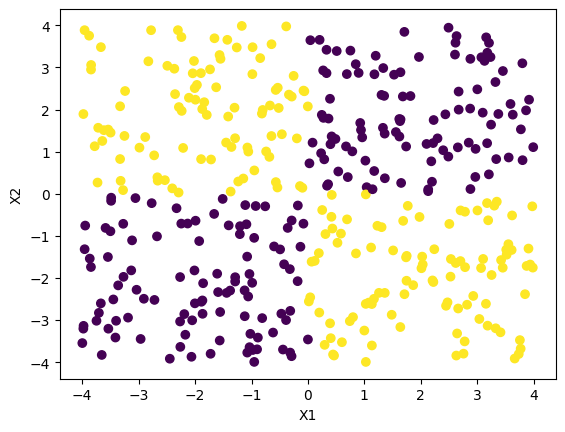

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.uniform(low=-4, high=4, size=(400,2))
y = np.bitwise_xor(np.sign(x[:,0]).astype(int),np.sign(x[:,1]).astype(int))
y[y==-2]=1
plt.scatter(x[:,0],x[:,1],c=y)
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()


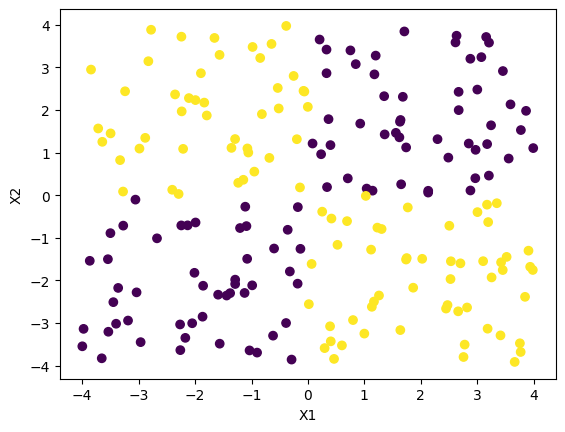

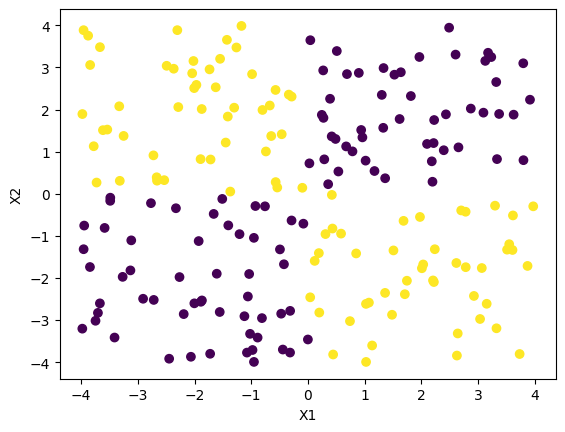

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

plt.scatter(x_train[:,0],x_train[:,1],c=y_train)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

plt.scatter(x_test[:,0],x_test[:,1],c=y_test)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


In [ ]:

def train_model(model,X_train,Y_train,X_test,Y_test,title):
  #loss_fn = nn.BCEWithLogitsLoss()
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  # Mini-batch training
  print_every = 100
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if epoch % print_every == 0:
          print(epoch, loss.item())
  X = np.linspace(-4, 4, 300)
  Y = np.linspace(-4, 4, 300)
  X, Y = np.meshgrid(X, Y)
  X_=np.c_[X.ravel(),Y.ravel()]
  X__=torch.tensor(X_,dtype=torch.float32).to(device)
  y_pred=model(X__).reshape(X.shape)
  #y_pred_sig=torch.sigmoid(y_pred)
  plt.figure(figsize=(8, 6))
  plt.contourf(X, Y, y_pred.detach().numpy(), cmap='coolwarm', alpha=0.5)
  plt.scatter(X_test.detach().numpy()[:,0],X_test.detach().numpy()[:,1],c=Y_test.detach().numpy(),cmap='coolwarm')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(title)
  plt.colorbar(label='Prediction')
  plt.show()


0 0.7794914841651917
100 0.3435633182525635
200 0.13436008989810944
300 0.07045090198516846
400 0.0427892729640007
500 0.027774589136242867
600 0.019631734117865562
700 0.014636478386819363
800 0.01142109651118517
900 0.009226963855326176
1000 0.007642033509910107
1100 0.006451532244682312
1200 0.00553202023729682
1300 0.0048069399781525135
1400 0.004222781863063574
1500 0.003746528411284089
1600 0.0033538402058184147
1700 0.0030196369625627995
1800 0.0027371826581656933
1900 0.002495719352737069
2000 0.0022861629258841276
2100 0.002103567821905017
2200 0.001942796865478158
2300 0.0017996609676629305
2400 0.0016725304303690791
2500 0.0015585171058773994
2600 0.0014547556638717651
2700 0.0013609075685963035
2800 0.0012757682707160711
2900 0.0011985809542238712
3000 0.001125933020375669
3100 0.001060302136465907
3200 0.0009989311220124364
3300 0.0009429377969354391
3400 0.000890315743163228
3500 0.0008418216020800173
3600 0.0007966745179146528
3700 0.0007543977117165923
3800 0.0007147261

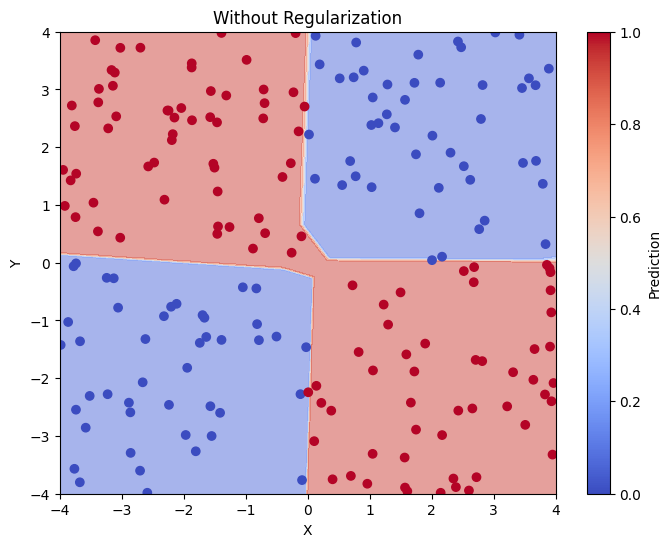

In [ ]:
# model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(), nn.Linear(4, 2),nn.Linear(2, 4), nn.ReLU(), nn.Linear(2, 1))
#model = nn.Sequential(nn.Linear(2, 4), nn.Tanh(), nn.Liner(4, 2),nn.Tanh(),nn.Linear(2,1))
model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
#model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(),nn.Linear(2,1))
#model = nn.Sequential(nn.Linear(2, 4), nn.Tanh(), nn.Linear(4, 2),nn.Tanh(),nn.Linear(2,1))
model.to(device)
X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model(model,X_train,Y_train,X_test,Y_test,"Without Regularization")

In [7]:
def compute_l1_loss(w):
      return torch.abs(w).sum()

def compute_l2_loss(w):
      return torch.square(w).sum()

In [8]:

def train_model_Reg(model,X_train,Y_train,X_test,Y_test,isL1,title,l1_weight,l2_weight):
  #loss_fn = nn.BCEWithLogitsLoss()
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  # Mini-batch training
  print_every = 100
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      #l1_weight = 0.3
      #l2_weight = 0.7

      # Compute L1 and L2 loss component
      parameters = []
      for parameter in model.parameters():
          parameters.append(parameter.view(-1))

      penalty_loss=0

      if isL1:
          penalty_loss = l1_weight * compute_l1_loss(torch.cat(parameters))
      else:
          penalty_loss = l2_weight * compute_l2_loss(torch.cat(parameters))

      # Add L1 and L2 loss components
      loss+=penalty_loss
      loss.backward()
      opt.step()
      opt.zero_grad()
      if epoch % print_every == 0:
          print(epoch, loss.item())
  X = np.linspace(-4, 4, 300)
  Y = np.linspace(-4, 4, 300)
  X, Y = np.meshgrid(X, Y)
  X_=np.c_[X.ravel(),Y.ravel()]
  X__=torch.tensor(X_,dtype=torch.float32).to(device)
  y_pred=model(X__).reshape(X.shape)
  #y_pred_sig=torch.sigmoid(y_pred)
  print(y_pred[0])
  plt.figure(figsize=(8, 6))
  plt.contourf(X, Y, y_pred.detach().numpy(), cmap='coolwarm', alpha=0.5)
  plt.scatter(X_test.detach().numpy()[:,0],X_test.detach().numpy()[:,1],c=Y_test.detach().numpy(),cmap='coolwarm')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(title)
  plt.colorbar(label='Prediction')
  #plt.grid(True)
  plt.show()


In [9]:
def train_and_validate(model,x_train,x_valid,y_train,y_valid,isL1,l1,l2):
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
  X_valid=torch.tensor(x_valid,dtype=torch.float32).to(device)
  Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
  Y_valid=torch.tensor(y_valid,dtype=torch.float32).to(device)
  Y_train=torch.unsqueeze(Y_train,dim=1)
  Y_valid=torch.unsqueeze(Y_valid,dim=1)
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      #l1_weight = 0.3
      #l2_weight = 0.7

      # Compute L1 and L2 loss component
      parameters = []
      for parameter in model.parameters():
          parameters.append(parameter.view(-1))

      penalty_loss=0

      if isL1:
          penalty_loss = l1 * compute_l1_loss(torch.cat(parameters))
      else:
          penalty_loss = l2 * compute_l2_loss(torch.cat(parameters))
      loss+=penalty_loss
      loss.backward()
      opt.step()
      opt.zero_grad()

  model.eval()  # Switch to evaluation mode
  val_loss = 0
  with torch.no_grad():
      outputs=model(X_valid)
      val_loss = loss_fn(outputs, Y_valid)
  return val_loss




In [13]:
x_train1, x_valid, y_train1, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
L1=[0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009]
best_val_loss = float('inf')
best_l1_coefficient = None
for l in L1:
  model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
  loss=train_and_validate(model,x_train1,x_valid,y_train1,y_valid,True,l1=l,l2=0.001)
  if loss<best_val_loss:
    best_val_loss=loss
    best_l1_coefficient = l
print(best_l1_coefficient)


0.003


In [14]:
x_train1, x_valid, y_train1, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
L2=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]
best_val_loss = float('inf')
best_l2_coefficient = None
for l in L2:
  model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
  loss=train_and_validate(model,x_train1,x_valid,y_train1,y_valid,True,l1=0.001,l2=l)
  if loss<best_val_loss:
    best_val_loss=loss
    best_l2_coefficient = l
print(best_l2_coefficient)

0.01


0 0.6678580045700073
100 0.2521187961101532
200 0.17333269119262695
300 0.1502559781074524
400 0.13904762268066406
500 0.13180403411388397
600 0.12573416531085968
700 0.12134121358394623
800 0.1197272539138794
900 0.1183762401342392
1000 0.11707024276256561
1100 0.11567467451095581
1200 0.11413273215293884
1300 0.11225581914186478
1400 0.10997846722602844
1500 0.10762788355350494
1600 0.10618922859430313
1700 0.10488961637020111
1800 0.10364094376564026
1900 0.10239418596029282
2000 0.10212298482656479
2100 0.10198960453271866
2200 0.10187803208827972
2300 0.10176481306552887
2400 0.10413689911365509
2500 0.10168692469596863
2600 0.10162311792373657
2700 0.10161381959915161
2800 0.10157369077205658
2900 0.10154514759778976
3000 0.10151796042919159
3100 0.10149645060300827
3200 0.10150332748889923
3300 0.10149392485618591
3400 0.1014636904001236
3500 0.10147158801555634
3600 0.10146446526050568
3700 0.1014399528503418
3800 0.10142168402671814
3900 0.10142996907234192
4000 0.101455383002

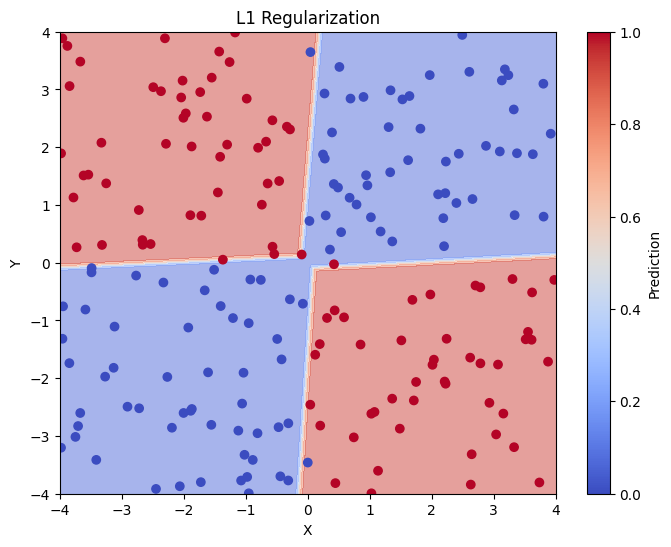

In [15]:


model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())

#model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(),nn.Linear(2,1))
#model = nn.Sequential(nn.Linear(2, 4), nn.Tanh(), nn.Linear(4, 2),nn.Tanh(),nn.Linear(2,1))
model.to(device)
X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model_Reg(model,X_train,Y_train,X_test,Y_test,True,"L1 Regularization",l1_weight=best_l1_coefficient,l2_weight=0.7)

0 0.7038151025772095
100 0.3836924433708191
200 0.33882129192352295
300 0.3175047039985657
400 0.3148120045661926
500 0.3144207000732422
600 0.31437551975250244
700 0.3143724799156189
800 0.31438368558883667
900 0.3143949508666992
1000 0.3143777549266815
1100 0.3143758177757263
1200 0.3143851161003113
1300 0.31437957286834717
1400 0.3143775463104248
1500 0.31437528133392334
1600 0.31437820196151733
1700 0.31439322233200073
1800 0.3143882751464844
1900 0.3144042491912842
2000 0.31438302993774414
2100 0.3143751621246338
2200 0.3143846392631531
2300 0.31437546014785767
2400 0.31438082456588745
2500 0.31438717246055603
2600 0.3143816590309143
2700 0.31438133120536804
2800 0.3143765926361084
2900 0.31439676880836487
3000 0.3143959045410156
3100 0.3143951892852783
3200 0.314395934343338
3300 0.3143833577632904
3400 0.314388632774353
3500 0.31440141797065735
3600 0.3143962025642395
3700 0.31439009308815
3800 0.3143919110298157
3900 0.31438782811164856
4000 0.314388632774353
4100 0.31438225507

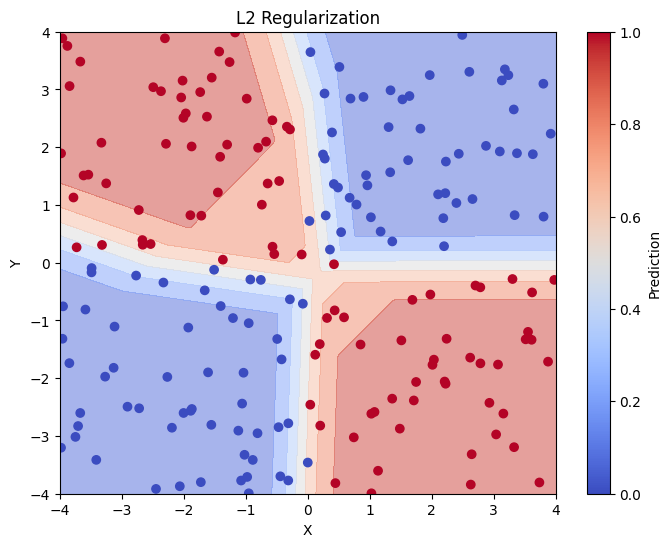

In [16]:
model = nn.Sequential(nn.Linear(2, 4), nn.ReLU(),nn.Linear(4,2), nn.ReLU(), nn.Linear(2,1),nn.Sigmoid())
#model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(),nn.Linear(2,1))
#model = nn.Sequential(nn.Linear(2, 4), nn.Tanh(), nn.Linear(4, 2),nn.Tanh(),nn.Linear(2,1))
model.to(device)
X_train=torch.tensor(x_train,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model_Reg(model,X_train,Y_train,X_test,Y_test,False,"L2 Regularization",l1_weight=0.001,l2_weight=best_l2_coefficient)

In [ ]:

def train_model_logistic(model,X_train,Y_train,X_test,Y_test,title):
  #loss_fn = nn.BCEWithLogitsLoss()
  loss_fn = nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=0.01)
  # Mini-batch training
  print_every = 100
  for epoch in range(10000):
      y_pred = model(X_train)
      #print(y_pred)
      #loss=F.binary_cross_entropy(y_pred,Y_test)
      loss = loss_fn(y_pred, Y_train)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if epoch % print_every == 0:
          print(epoch, loss.item())
  X = np.linspace(-4, 4, 300)
  Y = np.linspace(-4, 4, 300)
  X, Y = np.meshgrid(X, Y)
  X_=np.c_[X.ravel(),Y.ravel(),X.ravel()[:]*Y.ravel()[:]]
  X__=torch.tensor(X_,dtype=torch.float32).to(device)
  y_pred=model(X__).reshape(X.shape)
  #y_pred_sig=torch.sigmoid(y_pred)
  plt.figure(figsize=(8, 6))
  plt.contourf(X, Y, y_pred.detach().numpy(), cmap='coolwarm', alpha=0.5)
  plt.scatter(X_test.detach().numpy()[:,0],X_test.detach().numpy()[:,1],c=Y_test.detach().numpy(),cmap='coolwarm')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(title)
  plt.colorbar(label='Prediction')
  plt.show()


0 0.2786736786365509
100 0.14877460896968842
200 0.11757415533065796
300 0.10003460198640823
400 0.08817154169082642
500 0.07940695434808731
600 0.07258165627717972
700 0.0670742318034172
800 0.06251294910907745
900 0.05865822732448578
1000 0.055347226560115814
1100 0.05246472731232643
1200 0.04992636293172836
1300 0.047669023275375366
1400 0.045644283294677734
1500 0.04381437227129936
1600 0.04214936122298241
1700 0.040625281631946564
1800 0.039222538471221924
1900 0.0379251092672348
2000 0.036719661206007004
2100 0.03559506684541702
2200 0.03454190120100975
2300 0.033552248030900955
2400 0.03261925280094147
2500 0.031737059354782104
2600 0.030900605022907257
2700 0.03010547161102295
2800 0.029347814619541168
2900 0.028624268248677254
3000 0.02793184109032154
3100 0.027267925441265106
3200 0.02663016878068447
3300 0.026016507297754288
3400 0.025425083935260773
3500 0.024854226037859917
3600 0.02430245652794838
3700 0.023768436163663864
3800 0.02325093187391758
3900 0.02274885587394237

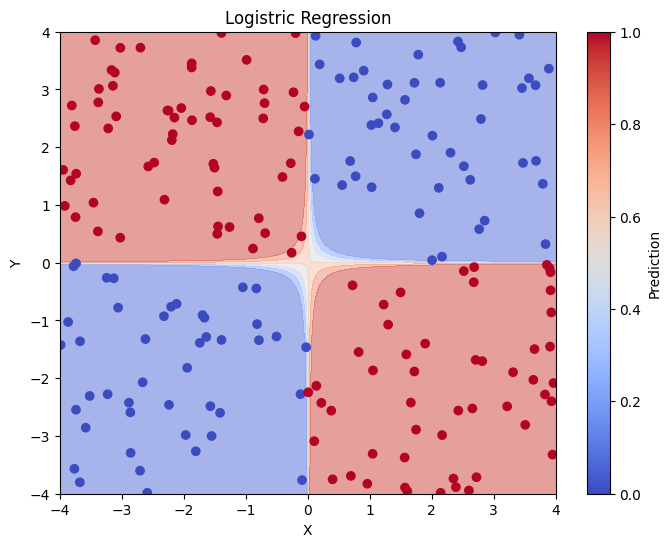

In [ ]:
model = nn.Sequential(nn.Linear(3,1),nn.Sigmoid())
#model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(),nn.Linear(2,1))
#model = nn.Sequential(nn.Linear(2, 4), nn.Tanh(), nn.Linear(4, 2),nn.Tanh(),nn.Linear(2,1))
model.to(device)
column=x_train[:,0]*x_train[:,1]
x_train_ = np.insert(x_train, 2, column, axis=1)
column=x_test[:,0]*x_test[:,1]
x_test_ = np.insert(x_test, 2, column, axis=1)
X_train=torch.tensor(x_train_,dtype=torch.float32).to(device)
X_test=torch.tensor(x_test_,dtype=torch.float32).to(device)
Y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
Y_train=torch.unsqueeze(Y_train,dim=1)
Y_test=torch.tensor(y_test,dtype=torch.float32).to(device)
Y_test=torch.unsqueeze(Y_test,dim=1)
train_model_logistic(model,X_train,Y_train,X_test,Y_test,"Logistric Regression")

Observations

1) Simple MLP without regularization

      -> We have used 2 hidden layer of size 4 and 2 respectively. Both layers
        have Relu activation function as non linearity. Output layer has one neuron and sigmoid function is applied to it.

      -> We trained over 10000 epochs with learning rate 0.01. We have got almost perfect decision boundary except 2-3 points are on the boundary line.

2) L1 Regularization

      -> Using validation data, We applied different weight coefficients for regularization. So finally ,we used 0.003 as a weight coefficient.

      -> Due to L1 regularization, weights goes down and some weights becomes completely zero. Due to that some points gives value close to zero at output layer which became 0.5 after applying sigmoid.

      -> So, In L1 regularization, we can see that decision boundary is not very sharp because some points around the boundary predicted value close to 0.5

3) L2 Regularization

      -> Using validation data, We applied different weight coefficients for regularization. So finally ,we used 0.01 as a weight coefficient.

      -> Due to L2 regularization, weights goes down and some weights becomes completely zero. Due to that some points gives value close to zero at output layer which became 0.5 after applying sigmoid

      -> So, In L2 regularization, we can see that decision boundary is not perfect as compared of L1 regularization.


4) Logistic regression

      -> In this we used x1*x2, as extra feature while training.

      -> We trained over 10000 epochs with learning rate 0.01. We have got almost perfect decision boundary except 2-3 points are on the boundary line.


      